In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from fastai.text.all import *
from sklearn.model_selection import train_test_split

In [4]:
GPT2LMHeadModel.from_pretrained?

In [2]:
pretrained_weights = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [3]:
path = Path()

In [4]:
data_path = (path/'StephenKing_txt')

In [4]:
data_path = (path/'HarryPotter_txt')

In [5]:
df = pd.DataFrame()
for txt_f in get_text_files(data_path):
    with open(txt_f, encoding='utf-8') as f:
        while True:
            txt = f.read(2048)
            if(txt == ''): break
            df = df.append([txt], ignore_index=True)

In [7]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [9]:
splits = train_test_split(list(range(df.count()[0])), test_size=0.1)
tls = TfmdLists(df[0].values, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [10]:
bs,sl = 8,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [11]:
dls.show_batch(max_n=2)

,text,text_
0,"urn, Christine led him there.\n\nThere was a long, frozen moment. A little moan escaped Leigh's throat. Arnie stood not quite halfway across the small parking lot, dressed in his high school jacket, faded jeans, boots. A plaid scarf was tied around his throat. The collar of his jacket was turned up, and its black wings framed a face that was slowly twisting from an expression of sick incredulity into a pallid grimace of hate, The red-and-white-striped bag with the Colonel's smiling face on it slipped out of one of his gloved hands and thumped onto the packed snow of the parking lot.\n\n""Dennis,"" Leigh whispered. ""Dennis, oh my God.""\n\nHe began to run. I thought he was coming to the car, probably to haul me out and work me over. I could see myself hopping feebly around on my not-so-good good leg under the parking-lot lights that had just come on while",", Christine led him there.\n\nThere was a long, frozen moment. A little moan escaped Leigh's throat. Arnie stood not quite halfway across the small parking lot, dressed in his high school jacket, faded jeans, boots. A plaid scarf was tied around his throat. The collar of his jacket was turned up, and its black wings framed a face that was slowly twisting from an expression of sick incredulity into a pallid grimace of hate, The red-and-white-striped bag with the Colonel's smiling face on it slipped out of one of his gloved hands and thumped onto the packed snow of the parking lot.\n\n""Dennis,"" Leigh whispered. ""Dennis, oh my God.""\n\nHe began to run. I thought he was coming to the car, probably to haul me out and work me over. I could see myself hopping feebly around on my not-so-good good leg under the parking-lot lights that had just come on while"
1,"]\n\nDetective Anderson: Well, Claude, it must be nice for you to be here when you’re not in trouble. Refreshing.\n\nBolton: You know, it kind of is. And to get a ride in the front of a police car instead of in the back. Ninety miles an hour most of the way back from Cap City. Lights, siren, the whole works. You’re right. It was nice.\n\nDetective Anderson: What were you doing in Cap?\n\nBolton: Seeing the sights. Had a couple of nights off, so why not? No law against it, is there?\n\nDetective Anderson: I understand you were seeing them with Carla Jeppeson, known as Pixie Dreamboat when she’s working.\n\nBolton: You should know, since she came back in the cruiser with me. She also appreciated the ride, by the way. Said it beat the hell out of Trailways.\n\nDetective Anderson: And the sights you saw, most of those would have been in Room 509 of","\n\nDetective Anderson: Well, Claude, it must be nice for you to be here when you’re not in trouble. Refreshing.\n\nBolton: You know, it kind of is. And to get a ride in the front of a police car instead of in the back. Ninety miles an hour most of the way back from Cap City. Lights, siren, the whole works. You’re right. It was nice.\n\nDetective Anderson: What were you doing in Cap?\n\nBolton: Seeing the sights. Had a couple of nights off, so why not? No law against it, is there?\n\nDetective Anderson: I understand you were seeing them with Carla Jeppeson, known as Pixie Dreamboat when she’s working.\n\nBolton: You should know, since she came back in the cruiser with me. She also appreciated the ride, by the way. Said it beat the hell out of Trailways.\n\nDetective Anderson: And the sights you saw, most of those would have been in Room 509 of"


In [12]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [13]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [14]:
learn.validate()

(#2) [3.683969020843506,39.8040657043457]

SuggestedLRs(valley=7.585775892948732e-05)

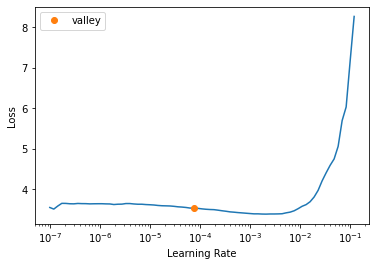

In [153]:
learn.lr_find()

In [15]:
%%time
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.360280,3.234969,25.405594,57:13


CPU times: total: 53min 42s
Wall time: 57min 13s


In [16]:
prompt = "It was a bright day."
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()

In [17]:
preds = learn.model.generate(inp, max_length=500, repetition_penalty=6.0,
                             temperature=1.5, no_repeat_ngram_size=2,
                             do_sample=True, top_k=5, top_p=0.95)
tokenizer.decode(preds[0].cpu().numpy())

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'It was a bright day.\n\'I\'ll get you some coffee, Bobby!\' she cried at last and got her cup back on the table before I could finish my meal—a nice surprise from someone who had been working in an office with two other people when we first started out here.\'\n\n "What are they doing? What\'s their plan?" She said to me like that..." The voice of one whose name has always stuck together is very clear now: It comes through his mouth instead! \'They\'re going after us,\' he says again, almost as if it might have happened without even knowing about himself; this time not exactly true but certainly plausible enough for him...and so does all those things... what can be done?\' And then there were three more words coming over both hands — “We’ll see eachother soon…if only just righteously … or else." He looked away slightly toward Mrs Arnie because no matter how much Mr Anderson thought something wasn\'t happening (it wouldn-be lying), Steve Darnell didnt think any better than either side 

In [ ]:
learn.export(path/'WriterHP_transf_model.pkl')

In [18]:
learn.export(path/'WriterStKng_transf_model.pkl')

In [ ]:
learn.save('writer_HarPot_transf_1epoch')

In [19]:
learn.save('writer_StKng_transf_1epoch')

Path('models/writer_StKng_transf_1epoch.pth')